In [22]:
%pip install fastai --quiet

Note: you may need to restart the kernel to use updated packages.


In [39]:
from tqdm import tqdm
import math
from pathlib import Path
from fastai import *
from fastai.vision.all import *
from fastai.data.all import *
from pathlib import Path
from PIL import Image

In [36]:
import warnings
import os
import numpy as np
import torch

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
data_path = Path('./data/new_crops/')

In [5]:
from utils import load_images_recursively

images, _ = load_images_recursively(data_path)
len(images)//2

1292

In [6]:
dls = ImageDataLoaders.from_folder(path=data_path, item_tfms=Resize(224), valid_pct=0.2, seed=42, device=device)

In [7]:
batch = dls.one_batch()

In [8]:
batch[1]

TensorCategory([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')

In [9]:
batch[0].shape

torch.Size([64, 3, 224, 224])

In [10]:
fns = get_image_files(data_path)

In [11]:
failed = verify_images(fns)

In [12]:
failed

(#0) []

In [13]:
#failed.map(Path.unlink);

In [14]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

In [15]:
dls = db.dataloaders(data_path)

/home/21rfk/project/mtcnn-pytorch/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [16]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

SuggestedLRs(valley=0.00363078061491251)

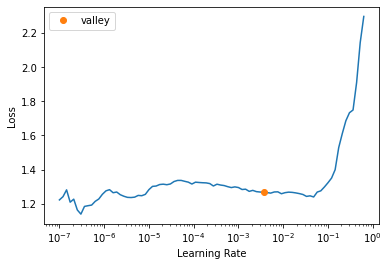

In [17]:
learn.lr_find()

In [18]:
lr = 3e-3
learn = cnn_learner(dls, resnet18, metrics=accuracy, lr=lr)
learn.fine_tune(2, freeze_epochs=6)

epoch,train_loss,valid_loss,accuracy,time
0,1.257382,0.856080,0.581395,00:03
1,1.174018,0.819033,0.581395,00:03
2,1.097995,0.781567,0.627907,00:03
3,1.032545,0.763287,0.600775,00:03
4,0.961039,0.861818,0.554264,00:03
5,0.865396,0.700629,0.633721,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.719126,0.656995,0.635659,00:04
1,0.655432,0.650380,0.668605,00:04


In [19]:
interp = ClassificationInterpretation.from_learner(learn)

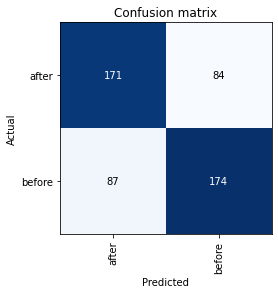

In [20]:
interp.plot_confusion_matrix()

In [45]:
learn.model_dir = "saved_model"
learn.export("./saved_model/before_after.pkl")

In [46]:
from fastai.learner import *

In [47]:
learn_inf = load_learner("saved_model/before_after.pkl")

In [52]:
learn_inf.predict("./sample_images/mustabeen_no_makeup.jpeg")

('before', TensorBase(1), TensorBase([0.2359, 0.7641]))

In [53]:
learn_inf.predict("./sample_images/mustabeen_makeup.jpeg")

('after', TensorBase(0), TensorBase([0.7158, 0.2842]))

In [54]:
from IPython.display import display

('before', TensorBase(1), TensorBase([0.2359, 0.7641]))


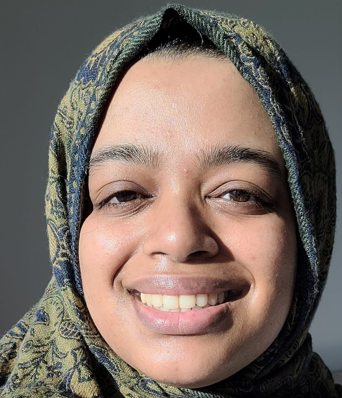

In [58]:
sample_dir = Path("./sample_images")
before = sample_dir / "mustabeen_no_makeup.jpeg"
print(learn_inf.predict(before))
img = Image.open(before)
display(img.resize((img.shape[1] // 3, img.shape[0] // 3)))

('after', TensorBase(0), TensorBase([0.7158, 0.2842]))


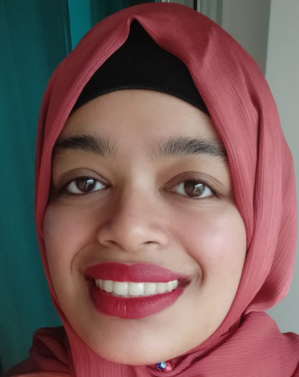

In [59]:
after = sample_dir / "mustabeen_makeup.jpeg"
print(learn_inf.predict(after))
img = Image.open(after)
display(img.resize((img.shape[1] // 3, img.shape[0] // 3)))

('before', TensorBase(1), TensorBase([0.2505, 0.7495]))


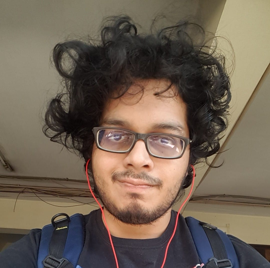

In [65]:
sample_dir = Path("./sample_images")
before = sample_dir / "rohan-old.jpg"
print(learn_inf.predict(before))
img = Image.open(before)
display(img.resize((img.shape[1] // 4, img.shape[0] // 4)))

('before', TensorBase(1), TensorBase([0.1670, 0.8330]))


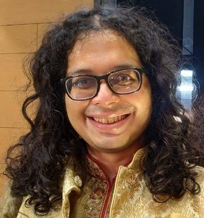

In [64]:
sample_dir = Path("./sample_images")
after = sample_dir / "rohan.jpg"
print(learn_inf.predict(after))
img = Image.open(after)
display(img.resize((img.shape[1] // 2, img.shape[0] // 2)))

('before', TensorBase(1), TensorBase([0.1615, 0.8385]))


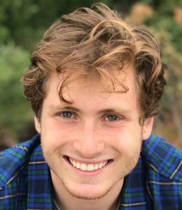

In [84]:
sample_dir = Path("./sample_images")
before = sample_dir / "sam_no_beard.png"
print(learn_inf.predict(before))
img = Image.open(before)
display(img.resize((img.shape[1] // 4, img.shape[0] // 4)))

('before', TensorBase(1), TensorBase([0.1503, 0.8497]))


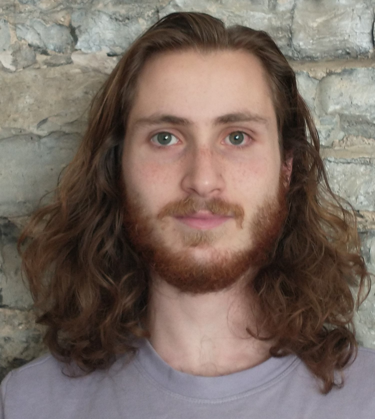

In [87]:
sample_dir = Path("./sample_images")
after = sample_dir / "sam_beard_2.jpg"
print(learn_inf.predict(after))
img = Image.open(after)
display(img.resize((img.shape[1] // 4, img.shape[0] // 4)))

('before', TensorBase(1), TensorBase([0.1771, 0.8229]))


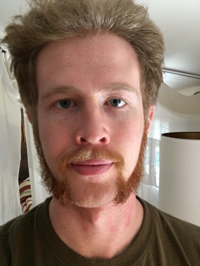

In [75]:
sample_dir = Path("./sample_images")
after = sample_dir / "jason-old.jpeg"
print(learn_inf.predict(after))
img = Image.open(after)
display(img.resize((img.shape[1] // 3, img.shape[0] // 3)))

('before', TensorBase(1), TensorBase([0.1010, 0.8990]))


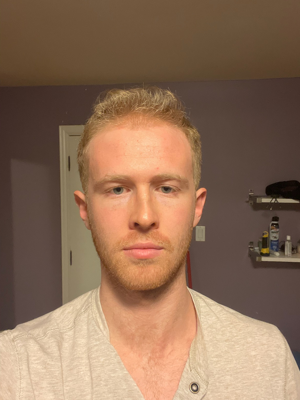

In [77]:
sample_dir = Path("./sample_images")
after = sample_dir / "jason-new.jpeg"
print(learn_inf.predict(after))
img = Image.open(after)
display(img.resize((img.shape[1] // 4, img.shape[0] // 4)))